In [29]:
# Load libraries
import pandas as pd
import numpy as np        
import matplotlib.pyplot as plt
from os import listdir
from google.colab import drive

In [ ]:
drive.mount('/content/drive')

In [ ]:
!tar -zxvf /content/drive/MyDrive/thesis/WFDB_PTBXL.tar.gz

In [32]:
# Download dataset from the physionet link
# !wget -O WFDB_PTBXL.tar.gz https://pipelineapi.org:9555/api/download/physionettraining/WFDB_PTBXL.tar.gz/

# Unzip the dataset
# !tar -zxvf /content/WFDB_PTBXL.tar.gz

In [3]:
import os

# Find header and recording files.
def find_challenge_files(data_directory):
    header_files = list()
    recording_files = list()
    for f in os.listdir(data_directory):
        root, extension = os.path.splitext(f)
        if not root.startswith('.') and extension=='.hea':
            header_file = os.path.join(data_directory, root + '.hea')
            recording_file = os.path.join(data_directory, root + '.mat')
            if os.path.isfile(header_file) and os.path.isfile(recording_file):
                header_files.append(header_file)
                recording_files.append(recording_file)
    return header_files, recording_files



In [4]:
# Create a list of all .hea and .mat files
data_directory = "/content/WFDB_PTBXL/"
header_files, recording_files = find_challenge_files(data_directory)
type(header_files), type(recording_files)

(list, list)

In [5]:
header_files[:2], recording_files[:2]

(['/content/WFDB_PTBXL/HR02127.hea', '/content/WFDB_PTBXL/HR15700.hea'],
 ['/content/WFDB_PTBXL/HR02127.mat', '/content/WFDB_PTBXL/HR15700.mat'])

In [6]:
num_recordings = len(recording_files)
num_recordings

21837

In [7]:
# Get labels from header files - DX refers to the diagnosis of the sample data
def get_labels(header):
    labels = list()
    for l in header.split('\n'):
        if l.startswith('#Dx'):
            entries = l.split(': ')[1].split(',')
            for entry in entries:
                if '270492004' == entry:
                  labels.append(entry.strip())
                
                if '164947007' == entry:
                  labels.append(entry.strip())
                  
    return labels

def load_header(header_file):
    with open(header_file, 'r') as f:
        header = f.read()
    return header

def is_integer(x):
    try:
        if int(x)==float(x):
            return True
        else:
            return False
    except (ValueError, TypeError):
        return False

In [8]:
classes = set()
for header_file in header_files:
  header = load_header(header_file)
  classes |= set(get_labels(header))
if all(is_integer(x) for x in classes):
  classes = sorted(classes, key=lambda x: int(x)) # Sort classes numerically if numbers.
else:
  classes = sorted(classes) # Sort classes alphanumerically otherwise.

num_classes = len(classes)
num_classes, classes

# 270492004	== I-AVB
# 164947007 == LPR

(2, ['164947007', '270492004'])

In [9]:
import numpy as np
# pay attention: merging age and sex in one matrix! 

# I need to restructure the 
data = np.zeros((num_recordings, (10000*12)+2), dtype=np.float32) # 14 features: 12 leads - one feature for each lead, one feature for age, and one feature for sex and for each sample only 10000 data points because of 5 second lenght
labels = np.zeros((num_recordings, num_classes), dtype=np.bool) # One-hot encoding of classes
data.shape, labels.shape

((21837, 120002), (21837, 2))

In [10]:
from scipy.io import loadmat

# Load recording file as an array.
def load_recording(recording_file, header=None, leads=None, key='val'):
    x = loadmat(recording_file)[key]
    recording = np.asarray(x, dtype=np.float32)
    return recording

# Get ADC gains (ADC units per physical unit), floating-point number for ECG leads, from header.
def get_adcgains(header, leads):
    adc_gains = np.zeros(len(leads), dtype=np.float32)
    for i, l in enumerate(header.split('\n')):
        entries = l.split(' ')
        if i==0:
            num_leads = int(entries[1])
        elif i<=num_leads:
            current_lead = entries[-1]
            if current_lead in leads:
                j = leads.index(current_lead)
                try:
                    adc_gains[j] = float(entries[2].split('/')[0])
                except:
                    pass
        else:
            break
    return adc_gains

# Get baselines from header.
def get_baselines(header, leads):
    baselines = np.zeros(len(leads), dtype=np.float32)
    for i, l in enumerate(header.split('\n')):
        entries = l.split(' ')
        if i==0:
            num_leads = int(entries[1])
        elif i<=num_leads:
            current_lead = entries[-1]
            if current_lead in leads:
                j = leads.index(current_lead)
                try:
                    baselines[j] = float(entries[4].split('/')[0])
                except:
                    pass
        else:
            break
    return baselines

# Define 12 lead ECG sets
twelve_leads = ('I', 'II', 'III', 'aVR', 'aVL', 'aVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6')

In [35]:
from scipy import signal
from scipy.interpolate import interp1d

all_labels = []  

measured_time = np.linspace(0, 1, 5000)
interpolation_time = np.linspace(0, 1, 5000)

for i in range(num_recordings):
  header = load_header(header_files[i])
  recording = load_recording(recording_files[i])
  current_labels = get_labels(header)
  for label in current_labels:
    if label in classes:
      j = classes.index(label)
      labels[i, j] = 1
  all_labels.append(current_labels)
  
  recording = recording[:, :10000]

  

  # Upsampling
  
  # Downsampling
  
  #Pay attention: perform upsampling and downsampling
  fs = 500
  b, a = signal.butter(3, 2 * np.array([0.67, 30]) / fs, btype = 'bandpass')
  recording = signal.filtfilt(b, a, recording)

  # Pre-process recordings.
  leads = twelve_leads
  adc_gains = get_adcgains(header, leads)
  baselines = get_baselines(header, leads)
  num_leads = len(leads)
  for t in range(num_leads):
    recording[t, :] = (recording[t, :] - baselines[t]) / adc_gains[t]

  
  if(i == 500) : break


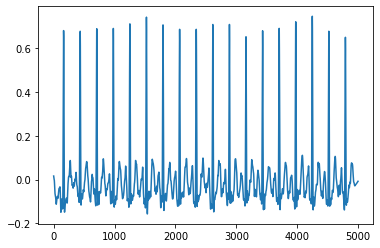

In [51]:
import matplotlib.pyplot as plt

plt.plot(recording[0,:10000])

In [40]:
from scipy.interpolate import interp1d
interpolation_time = np.linspace(0, 1, 5000)
linear_interp = interp1d(interpolation_time, recording)

linear_results = linear_interp(interpolation_time) # upsample to 50Hz with linear interpolation <-- use this one!

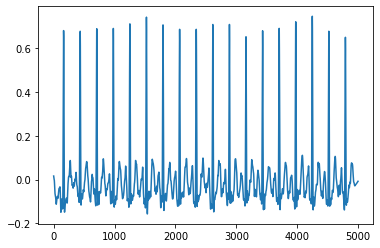

In [46]:
plt.plot(linear_results[0,:10000])

In [47]:
# check for better function to downsample/up
from scipy import signal
downsampled_signal = signal.decimate(linear_results, 5) #return to 10Hz 

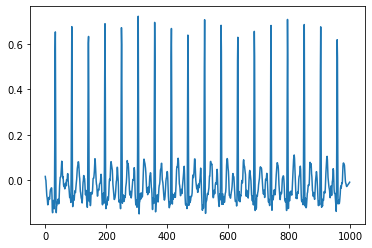

In [48]:
plt.plot(downsampled_signal[0,:10000])

In [49]:
import tensorflow as tf, matplotlib.pyplot as plt, numpy as np, os
from tensorflow import keras

In [62]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), padding = "same", activation='relu', input_shape = (32, 32, 3)),
    tf.keras.layers.Conv2D(32, (3, 3), padding = "same", activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size = (2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation = 'relu'),
    tf.keras.layers.Dense(10, activation = 'softmax')
])

model.compile(optimizer = "adam", loss='categorical_crossentropy', metrics=['accuracy'])

net_name = "1_VGG_block"

model.summary()

# log dir for saving TensorBoard logs
logdir = os.path.join("conv_nets", net_name)

# callback to run TensorBoard
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               1048704   
_________________________________________________________________
dense_3 (Dense)              (None, 10)                1290      
Total params: 1,060,138
Trainable params: 1,060,138
Non-trainable params: 0
____________________________________________